In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report
import pandas as pd
import json
import importlib
import math



try:
    from IPython import get_ipython
    if 'IPKernelApp' not in get_ipython().config:  # Not in a notebook
        from tqdm import tqdm
    else:  # In a notebook
        from tqdm.notebook import tqdm
except ImportError:  # IPython is not installed
    from tqdm import tqdm
import utils
from utils import *

# importlib.reload(utils)


# 2. set up for using GPU if available (with printed confirmation)  
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# 3. checking environment 
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except:
    IN_COLAB = False

Using cuda device


In [5]:
# model_test = BaselineNet().to(device)
# summary(model_test, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
         MaxPool2d-2           [-1, 16, 16, 16]               0
            Conv2d-3           [-1, 32, 16, 16]           4,640
         MaxPool2d-4             [-1, 32, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          18,496
         MaxPool2d-6             [-1, 64, 4, 4]               0
            Linear-7                   [-1, 64]          65,600
            Linear-8                   [-1, 10]             650
Total params: 89,834
Trainable params: 89,834
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.27
Params size (MB): 0.34
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


BaselineNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [3]:
batch_size = 64

torch.manual_seed(0)

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_data = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_data = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform)

num_validation_samples = 5000
num_train_samples = len(train_data) - num_validation_samples

train_data, val_data = random_split(train_data, [num_train_samples, num_validation_samples])

print(len(train_data)) # 50000 training egs  
print(len(val_data)) # 10000 test egs
print(len(test_data)) # 10000 test egs

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Files already downloaded and verified
45000
5000
10000


In [13]:
print(list(range(1)))

[0]


In [5]:
# 1.1 pick learning rate

num_epochs = 50
random_seeds = list(range(1, 6))

learning_rates_for_experiment = [0.1, 0.075, 0.05, 0.025, 0.01]
averaged_results = {lr:{} for lr in learning_rates_for_experiment}
path_to_save = f'./run_data/learning_rates/FINAL.json'
path_to_load = f'./run_data//learning_rates/FINAL.json'
save_experiment = True

for learning_rate in learning_rates_for_experiment:
    
    print('LR: ', learning_rate) 
    epoch_train_losses_by_run = []
    epoch_val_losses_by_run = []
    epoch_train_accuracies_by_run = []
    epoch_val_accuracies_by_run = []
    test_losses = []
    test_accuracies = []
    reports = []
       
    for random_seed in random_seeds:
        
        print('lr: ', learning_rate) 
        print('seed:', random_seed)
        torch.manual_seed(random_seed)
        
        model = BaselineNet().to(device)
        criterion = nn.CrossEntropyLoss()
        optimiser = optim.SGD(model.parameters(), lr=learning_rate)

        model, train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, _,_ = run_training_and_validation(model, device, learning_rate, num_epochs, criterion, optimiser, train_dataloader, val_dataloader, manual_lr_schedule=False, plot=True)
        epoch_train_losses_by_run.append(train_epoch_losses)
        epoch_val_losses_by_run.append(val_epoch_losses)
        epoch_train_accuracies_by_run.append(train_epoch_accuracy)
        epoch_val_accuracies_by_run.append(val_epoch_accuracy)
        
        test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        reports.append(report)
    
    average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
    average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
    average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
    average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
    
    average_test_loss = sum(test_losses)/len(test_losses)
    average_test_accuracy = sum(test_accuracies)/len(test_accuracies)
    
    averaged_results[learning_rate] = {'seeds':random_seeds,
                                       'av_train_losses': average_train_losses,
                                       'av_val_losses': average_val_losses,
                                       'av_train_acc': average_train_accuracies,
                                       'av_val_acc': average_val_accuracies,
                                       'all_train_losses':epoch_train_losses_by_run,
                                       'all_val_losses': epoch_val_losses_by_run,
                                       'all_train_accuracies': epoch_train_accuracies_by_run,
                                       'all_val_accuracies': epoch_val_accuracies_by_run,
                                       'all_test_losses':test_losses, 
                                       'all_test_accuracies':test_accuracies,
                                       'av_test_loss': average_test_loss,
                                       'av_test_accuracy':average_test_accuracy}
    plot_single_train_val_smoothed(average_train_losses,average_val_losses,average_train_accuracies,average_val_accuracies, num_epochs, smoothing_window=5, title=f'lr: {learning_rate}')

if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read

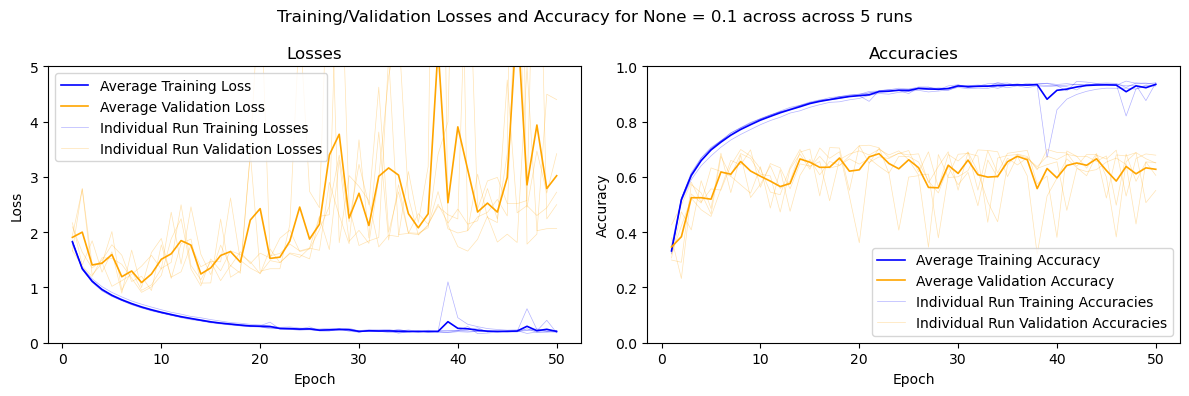

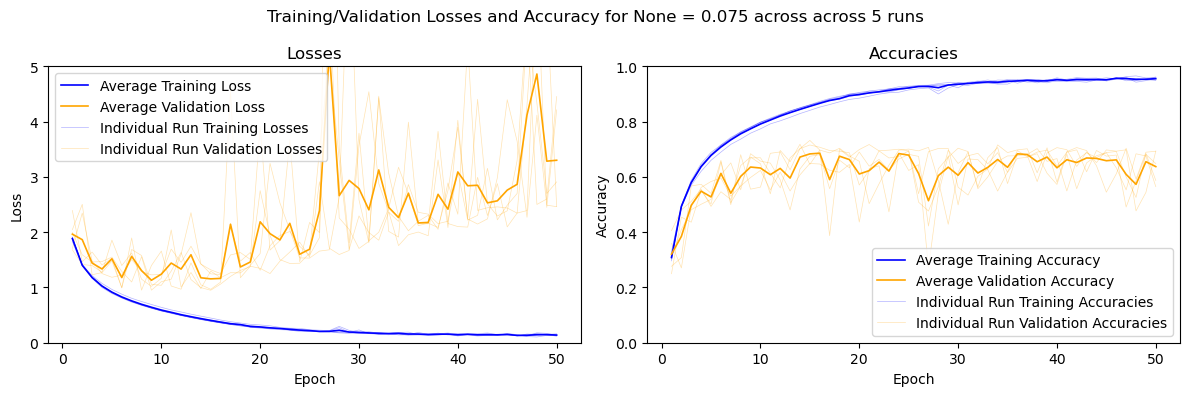

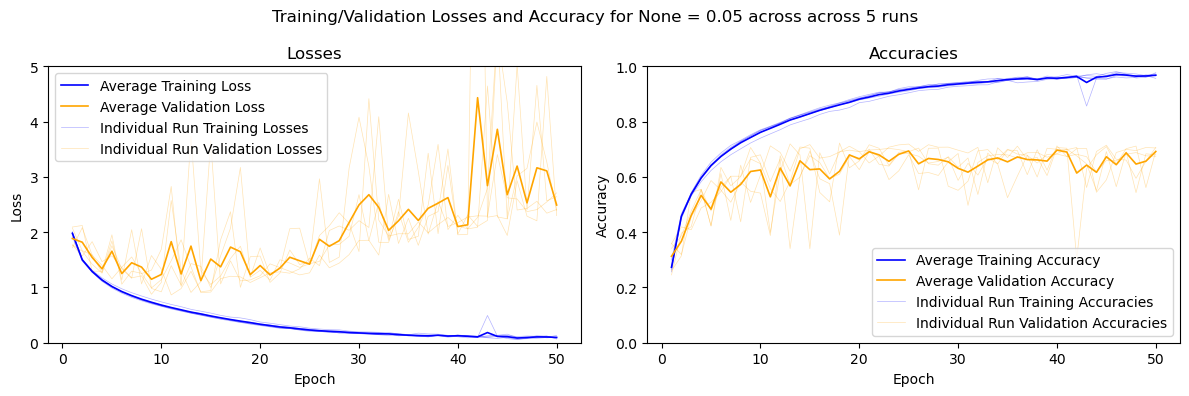

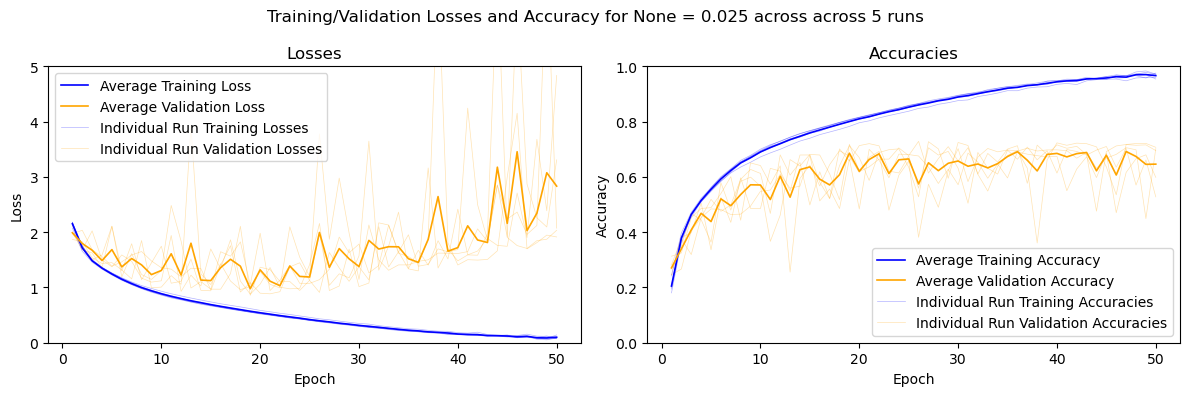

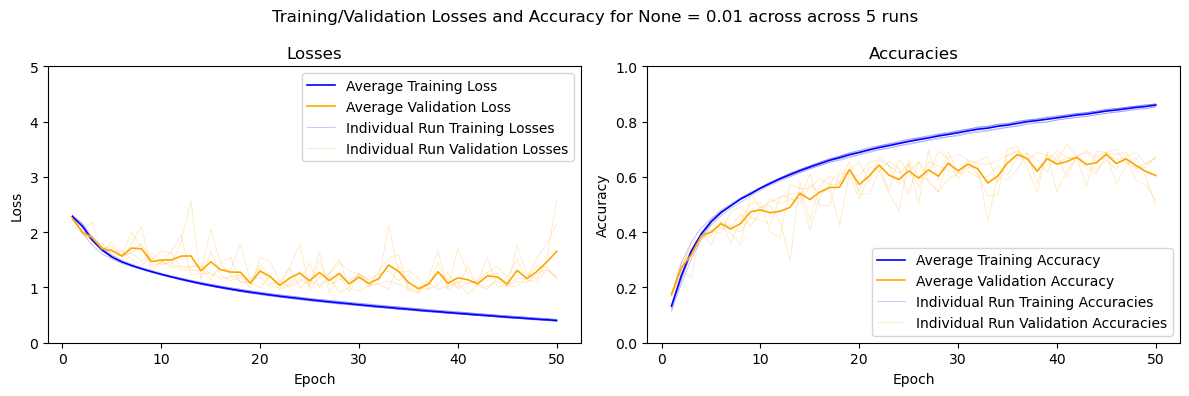

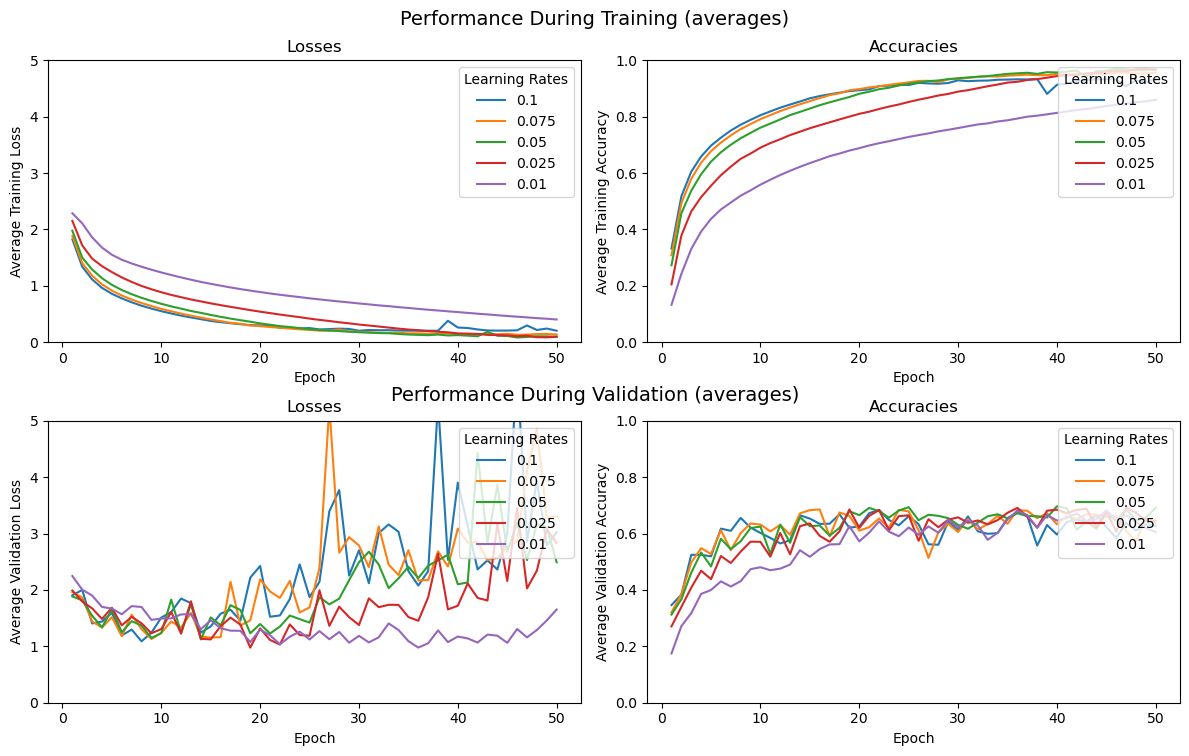

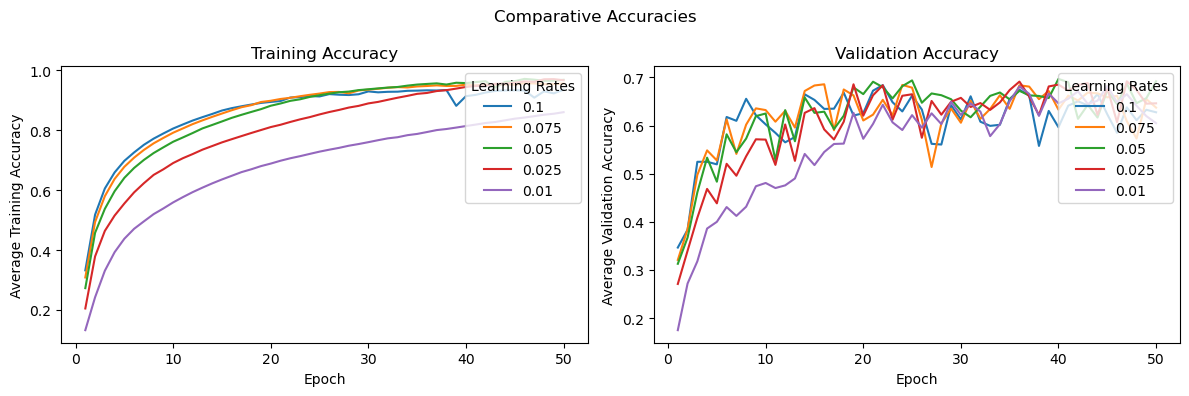

hi


,Average Test Loss,Average Test Accuracy
0.1,3.052043,0.626294
0.075,3.278138,0.640008
0.05,2.456172,0.693173
0.025,2.846509,0.645064
0.01,1.658107,0.604061


In [6]:
lr_data = path_to_load
plot_all_models_performance_from_disk(lr_data, enforce_axis=True)
plot_performance_comparison_from_file(lr_data, enforce_axis=True)
display_accuracy_heatmap(lr_data)

LR:  0.01
lr:  0.01
seed: 1
Epoch [1/75] - Train Loss: 2.2978, Acc: 0.1197 | Val Loss: 2.2866, Acc: 0.1707
Epoch [2/75] - Train Loss: 2.1681, Acc: 0.2262 | Val Loss: 2.0137, Acc: 0.2714
Epoch [3/75] - Train Loss: 1.8821, Acc: 0.3236 | Val Loss: 1.8349, Acc: 0.3463
Epoch [4/75] - Train Loss: 1.6688, Acc: 0.3962 | Val Loss: 1.6714, Acc: 0.3934
Epoch [5/75] - Train Loss: 1.5375, Acc: 0.4452 | Val Loss: 1.5534, Acc: 0.4294
Epoch [6/75] - Train Loss: 1.4529, Acc: 0.4745 | Val Loss: 1.5928, Acc: 0.4126
Epoch [7/75] - Train Loss: 1.3909, Acc: 0.4975 | Val Loss: 1.5996, Acc: 0.4231
Epoch [8/75] - Train Loss: 1.3372, Acc: 0.5206 | Val Loss: 1.7521, Acc: 0.4082
Epoch [9/75] - Train Loss: 1.2906, Acc: 0.5375 | Val Loss: 1.4746, Acc: 0.4652
Epoch [10/75] - Train Loss: 1.2431, Acc: 0.5583 | Val Loss: 1.7010, Acc: 0.4320
Epoch [11/75] - Train Loss: 1.2019, Acc: 0.5747 | Val Loss: 1.6141, Acc: 0.4296
Epoch [12/75] - Train Loss: 1.1606, Acc: 0.5906 | Val Loss: 1.3498, Acc: 0.5326
Epoch [13/75] - Train

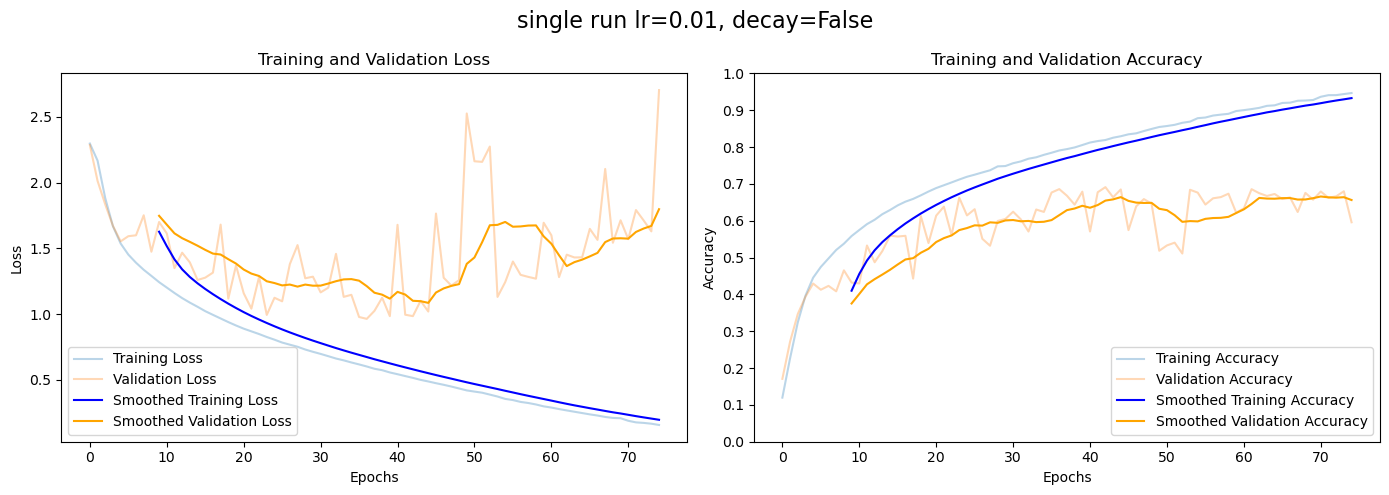

TESTING COMPLETE!!
Test Loss: 2.6516, Test Acc: 0.6086
              precision    recall  f1-score   support

       plane       0.37      0.91      0.53      1000
         car       0.74      0.77      0.75      1000
        bird       0.81      0.17      0.28      1000
         cat       0.59      0.28      0.38      1000
        deer       0.70      0.45      0.55      1000
         dog       0.56      0.57      0.57      1000
        frog       0.74      0.70      0.72      1000
       horse       0.61      0.79      0.69      1000
        ship       0.78      0.71      0.75      1000
       truck       0.71      0.74      0.72      1000

    accuracy                           0.61     10000
   macro avg       0.66      0.61      0.59     10000
weighted avg       0.66      0.61      0.59     10000

lr:  0.01
seed: 2
Epoch [1/75] - Train Loss: 2.2968, Acc: 0.1290 | Val Loss: 2.2801, Acc: 0.1709
Epoch [2/75] - Train Loss: 2.1045, Acc: 0.2496 | Val Loss: 1.9720, Acc: 0.2915
Epoch [3/7

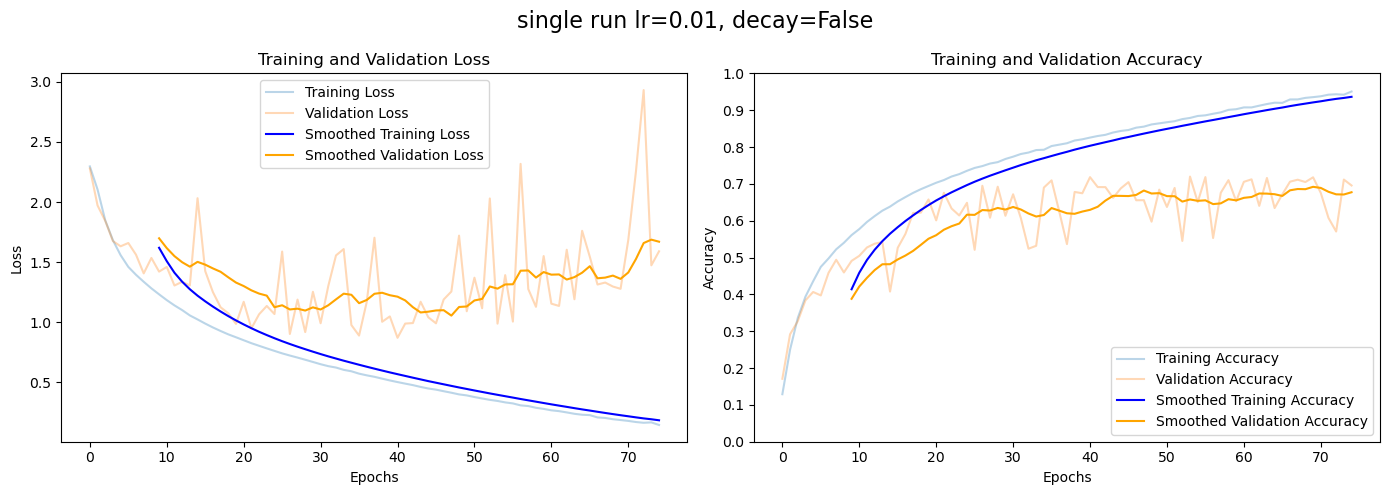

TESTING COMPLETE!!
Test Loss: 1.5880, Test Acc: 0.7019
              precision    recall  f1-score   support

       plane       0.71      0.79      0.75      1000
         car       0.79      0.84      0.81      1000
        bird       0.65      0.59      0.62      1000
         cat       0.47      0.56      0.51      1000
        deer       0.58      0.79      0.67      1000
         dog       0.63      0.56      0.59      1000
        frog       0.82      0.69      0.75      1000
       horse       0.87      0.62      0.72      1000
        ship       0.89      0.76      0.82      1000
       truck       0.77      0.82      0.80      1000

    accuracy                           0.70     10000
   macro avg       0.72      0.70      0.70     10000
weighted avg       0.72      0.70      0.70     10000

lr:  0.01
seed: 3
Epoch [1/75] - Train Loss: 2.2920, Acc: 0.1282 | Val Loss: 2.2659, Acc: 0.1652
Epoch [2/75] - Train Loss: 2.1360, Acc: 0.2329 | Val Loss: 2.0462, Acc: 0.2634
Epoch [3/7

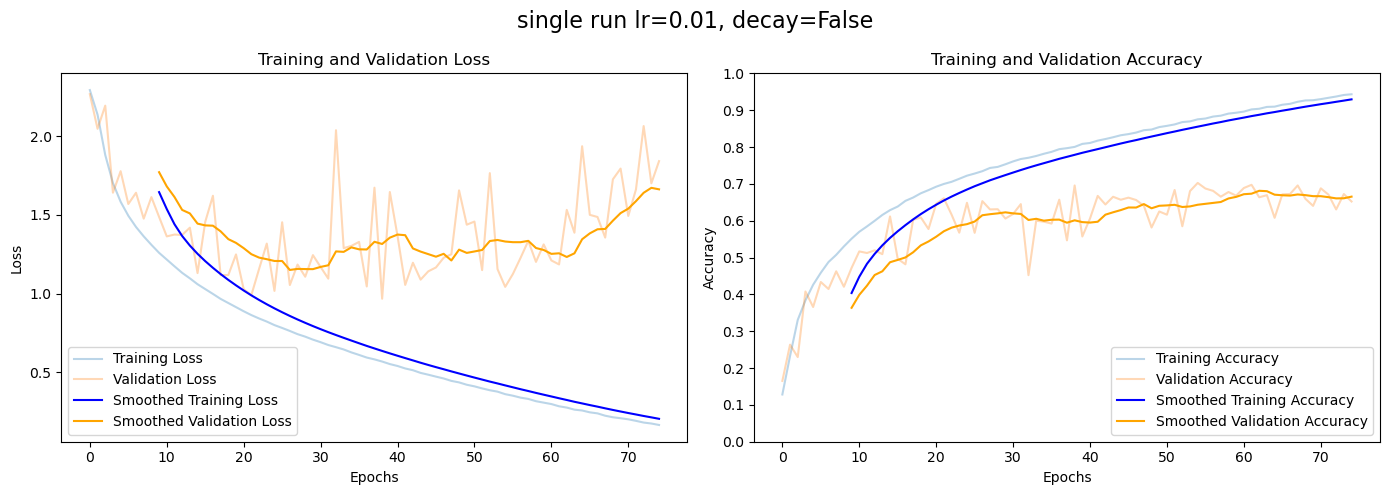

TESTING COMPLETE!!
Test Loss: 1.8463, Test Acc: 0.6502
              precision    recall  f1-score   support

       plane       0.79      0.65      0.72      1000
         car       0.84      0.74      0.79      1000
        bird       0.37      0.81      0.51      1000
         cat       0.47      0.48      0.48      1000
        deer       0.67      0.54      0.60      1000
         dog       0.63      0.50      0.56      1000
        frog       0.88      0.49      0.63      1000
       horse       0.79      0.69      0.74      1000
        ship       0.86      0.75      0.80      1000
       truck       0.72      0.85      0.78      1000

    accuracy                           0.65     10000
   macro avg       0.70      0.65      0.66     10000
weighted avg       0.70      0.65      0.66     10000

lr:  0.01
seed: 4
Epoch [1/75] - Train Loss: 2.2971, Acc: 0.1119 | Val Loss: 2.2822, Acc: 0.1327
Epoch [2/75] - Train Loss: 2.1441, Acc: 0.2128 | Val Loss: 2.0032, Acc: 0.2716
Epoch [3/7

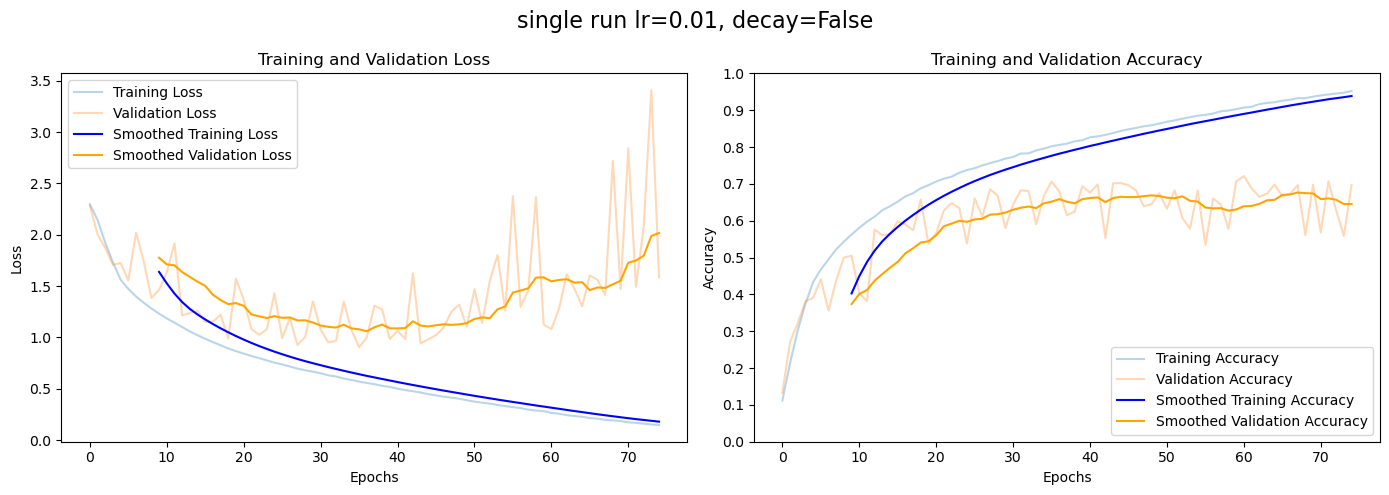

TESTING COMPLETE!!
Test Loss: 1.5541, Test Acc: 0.6980
              precision    recall  f1-score   support

       plane       0.73      0.77      0.75      1000
         car       0.79      0.85      0.82      1000
        bird       0.60      0.65      0.63      1000
         cat       0.43      0.65      0.52      1000
        deer       0.67      0.58      0.63      1000
         dog       0.68      0.49      0.57      1000
        frog       0.85      0.67      0.75      1000
       horse       0.75      0.75      0.75      1000
        ship       0.79      0.84      0.81      1000
       truck       0.85      0.72      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.72      0.70      0.70     10000
weighted avg       0.72      0.70      0.70     10000

lr:  0.01
seed: 5
Epoch [1/75] - Train Loss: 2.2506, Acc: 0.1751 | Val Loss: 2.1223, Acc: 0.2334
Epoch [2/75] - Train Loss: 1.9867, Acc: 0.2893 | Val Loss: 1.9919, Acc: 0.2579
Epoch [3/7

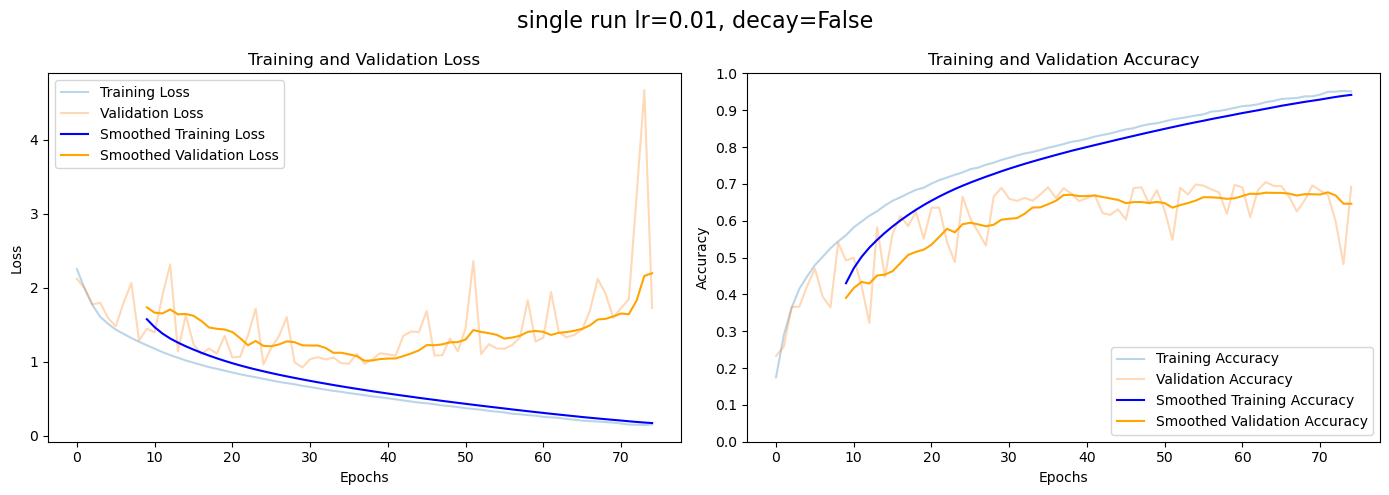

TESTING COMPLETE!!
Test Loss: 1.7451, Test Acc: 0.6807
              precision    recall  f1-score   support

       plane       0.66      0.81      0.73      1000
         car       0.86      0.75      0.80      1000
        bird       0.71      0.46      0.56      1000
         cat       0.44      0.52      0.47      1000
        deer       0.68      0.60      0.64      1000
         dog       0.51      0.65      0.57      1000
        frog       0.76      0.74      0.75      1000
       horse       0.77      0.71      0.74      1000
        ship       0.86      0.75      0.80      1000
       truck       0.72      0.81      0.76      1000

    accuracy                           0.68     10000
   macro avg       0.70      0.68      0.68     10000
weighted avg       0.70      0.68      0.68     10000



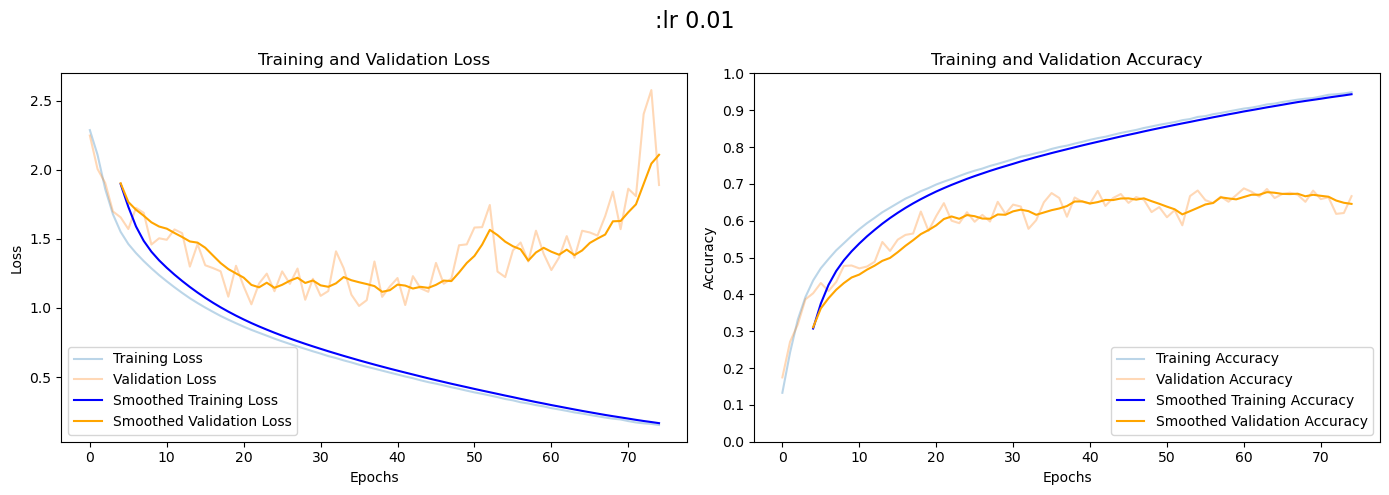

In [7]:
# 1.1 ECTRA EPOCHS FOR NON PLATEUAED LR

num_epochs = 75
random_seeds = list(range(1, 6))

learning_rates_for_experiment = [0.01]
averaged_results = {lr:{} for lr in learning_rates_for_experiment}
path_to_save = f'./run_data/learning_rates/FINAL_001_Extra.json'
path_to_load = f'./run_data//learning_rates/FINAL_001_Extra.json'
save_experiment = True

for learning_rate in learning_rates_for_experiment:
    
    print('LR: ', learning_rate) 
    epoch_train_losses_by_run = []
    epoch_val_losses_by_run = []
    epoch_train_accuracies_by_run = []
    epoch_val_accuracies_by_run = []
    test_losses = []
    test_accuracies = []
    reports = []
       
    for random_seed in random_seeds:
        
        print('lr: ', learning_rate) 
        print('seed:', random_seed)
        torch.manual_seed(random_seed)
        
        model = BaselineNet().to(device)
        criterion = nn.CrossEntropyLoss()
        optimiser = optim.SGD(model.parameters(), lr=learning_rate)

        model, train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, _,_ = run_training_and_validation(model, device, learning_rate, num_epochs, criterion, optimiser, train_dataloader, val_dataloader, manual_lr_schedule=False, plot=True)
        epoch_train_losses_by_run.append(train_epoch_losses)
        epoch_val_losses_by_run.append(val_epoch_losses)
        epoch_train_accuracies_by_run.append(train_epoch_accuracy)
        epoch_val_accuracies_by_run.append(val_epoch_accuracy)
        
        test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)
        reports.append(report)
    
    average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
    average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
    average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
    average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
    
    average_test_loss = sum(test_losses)/len(test_losses)
    average_test_accuracy = sum(test_accuracies)/len(test_accuracies)
    
    averaged_results[learning_rate] = {'seeds':random_seeds,
                                       'av_train_losses': average_train_losses,
                                       'av_val_losses': average_val_losses,
                                       'av_train_acc': average_train_accuracies,
                                       'av_val_acc': average_val_accuracies,
                                       'all_train_losses':epoch_train_losses_by_run,
                                       'all_val_losses': epoch_val_losses_by_run,
                                       'all_train_accuracies': epoch_train_accuracies_by_run,
                                       'all_val_accuracies': epoch_val_accuracies_by_run,
                                       'all_test_losses':test_losses, 
                                       'all_test_accuracies':test_accuracies,
                                       'av_test_loss': average_test_loss,
                                       'av_test_accuracy':average_test_accuracy}
    plot_single_train_val_smoothed(average_train_losses,average_val_losses,average_train_accuracies,average_val_accuracies, num_epochs, smoothing_window=5, title=f':lr {learning_rate}')

if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read

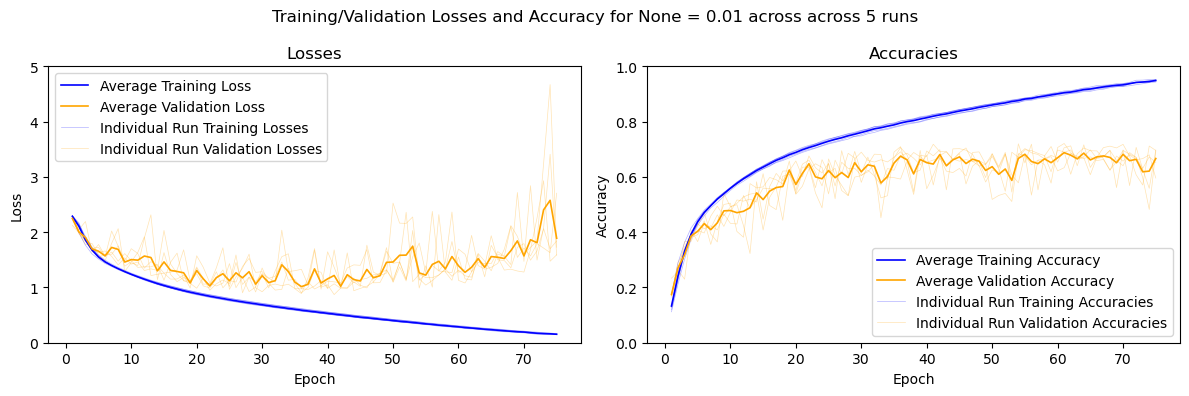

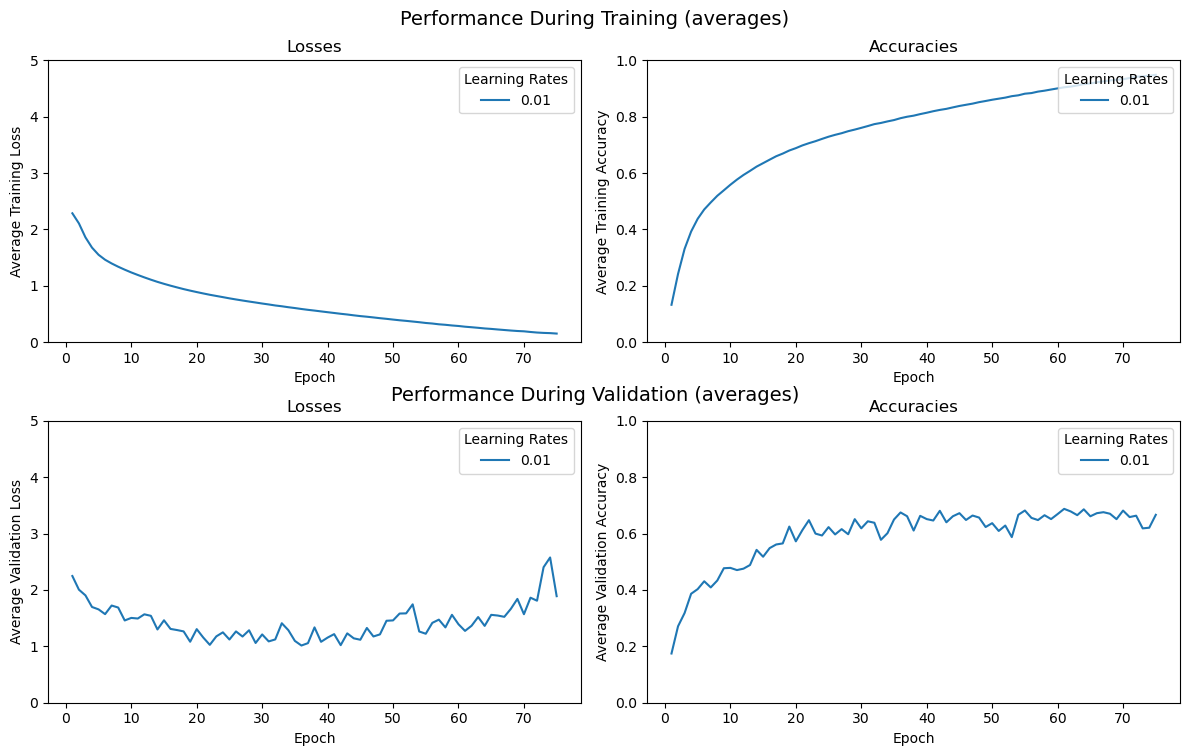

hi


,Average Test Loss,Average Test Accuracy
0.01,1.877034,0.667894


In [8]:
extra_lr_data = path_to_load
plot_all_models_performance_from_disk(extra_lr_data, enforce_axis=True)
plot_performance_comparison_from_file(extra_lr_data, enforce_axis=True)
display_accuracy_heatmap(extra_lr_data)

ADJUSTING!


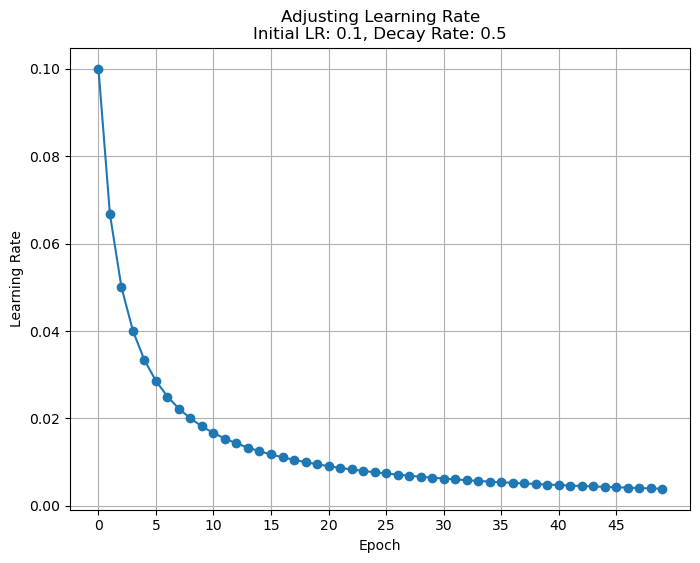

In [20]:
plot_adjusting_lr(initial_lr=0.1, decay_rate=0.5, num_epochs=50)

DECAY:  0.25
seed: 1
LR: 0.1
Epoch [1/50] - Train Loss: 1.8346, Acc: 0.3279 | Val Loss: 1.6864, Acc: 0.3724
LR: 0.08
Epoch [2/50] - Train Loss: 1.3511, Acc: 0.5144 | Val Loss: 2.3498, Acc: 0.2775
LR: 0.06666666666666667
Epoch [3/50] - Train Loss: 1.1514, Acc: 0.5907 | Val Loss: 1.3349, Acc: 0.5439
LR: 0.05714285714285715
Epoch [4/50] - Train Loss: 1.0165, Acc: 0.6397 | Val Loss: 1.2733, Acc: 0.5595
LR: 0.05
Epoch [5/50] - Train Loss: 0.9161, Acc: 0.6753 | Val Loss: 1.0449, Acc: 0.6319
LR: 0.044444444444444446
Epoch [6/50] - Train Loss: 0.8401, Acc: 0.7035 | Val Loss: 1.0408, Acc: 0.6442
LR: 0.04
Epoch [7/50] - Train Loss: 0.7727, Acc: 0.7280 | Val Loss: 1.4373, Acc: 0.5494
LR: 0.03636363636363637
Epoch [8/50] - Train Loss: 0.7174, Acc: 0.7477 | Val Loss: 1.0582, Acc: 0.6278
LR: 0.03333333333333333
Epoch [9/50] - Train Loss: 0.6670, Acc: 0.7660 | Val Loss: 1.8180, Acc: 0.4604
LR: 0.03076923076923077
Epoch [10/50] - Train Loss: 0.6238, Acc: 0.7817 | Val Loss: 1.0290, Acc: 0.6630
LR: 0.02

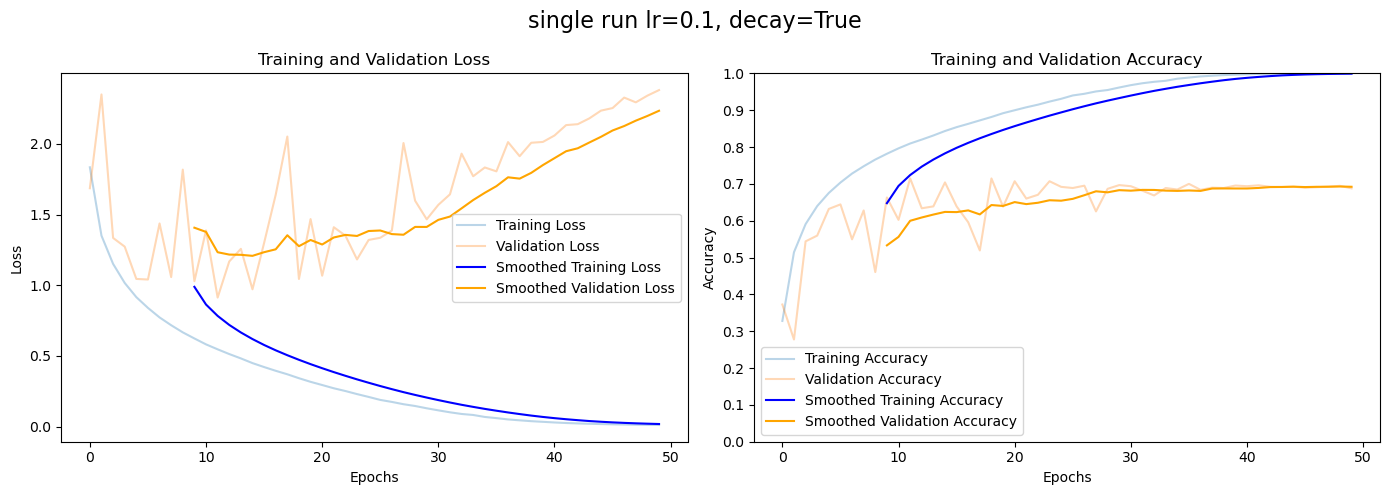

TESTING COMPLETE!!
Test Loss: 2.3595, Test Acc: 0.6971
              precision    recall  f1-score   support

       plane       0.75      0.74      0.75      1000
         car       0.85      0.80      0.82      1000
        bird       0.59      0.61      0.60      1000
         cat       0.48      0.49      0.48      1000
        deer       0.62      0.66      0.64      1000
         dog       0.60      0.60      0.60      1000
        frog       0.78      0.72      0.75      1000
       horse       0.74      0.75      0.74      1000
        ship       0.82      0.82      0.82      1000
       truck       0.77      0.79      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.70      0.70      0.70     10000
weighted avg       0.70      0.70      0.70     10000



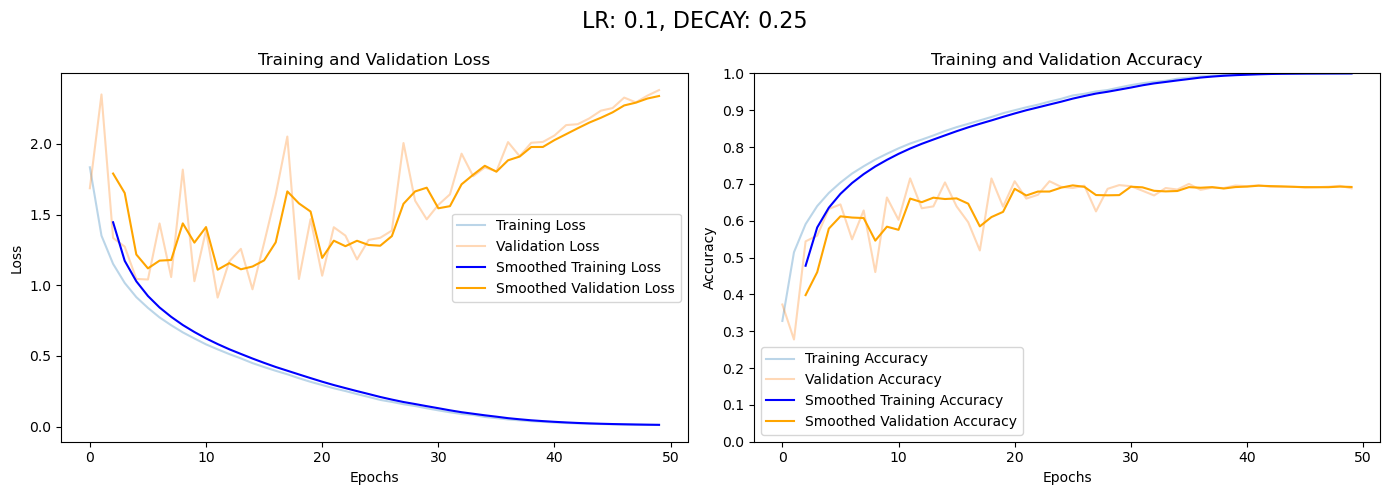

DECAY:  0.25
seed: 2
LR: 0.1
Epoch [1/50] - Train Loss: 1.8286, Acc: 0.3301 | Val Loss: 1.6577, Acc: 0.4203
LR: 0.08
Epoch [2/50] - Train Loss: 1.3411, Acc: 0.5162 | Val Loss: 1.3810, Acc: 0.5020
LR: 0.06666666666666667
Epoch [3/50] - Train Loss: 1.1154, Acc: 0.6012 | Val Loss: 1.2497, Acc: 0.5613
LR: 0.05714285714285715
Epoch [4/50] - Train Loss: 0.9694, Acc: 0.6553 | Val Loss: 1.3564, Acc: 0.5496
LR: 0.05
Epoch [5/50] - Train Loss: 0.8675, Acc: 0.6938 | Val Loss: 1.5730, Acc: 0.5320
LR: 0.044444444444444446
Epoch [6/50] - Train Loss: 0.7840, Acc: 0.7216 | Val Loss: 1.2021, Acc: 0.6028
LR: 0.04
Epoch [7/50] - Train Loss: 0.7155, Acc: 0.7476 | Val Loss: 1.0746, Acc: 0.6475
LR: 0.03636363636363637
Epoch [8/50] - Train Loss: 0.6600, Acc: 0.7683 | Val Loss: 1.4145, Acc: 0.5912
LR: 0.03333333333333333
Epoch [9/50] - Train Loss: 0.6096, Acc: 0.7865 | Val Loss: 0.8609, Acc: 0.7104
LR: 0.03076923076923077
Epoch [10/50] - Train Loss: 0.5654, Acc: 0.8026 | Val Loss: 0.9302, Acc: 0.6948
LR: 0.02

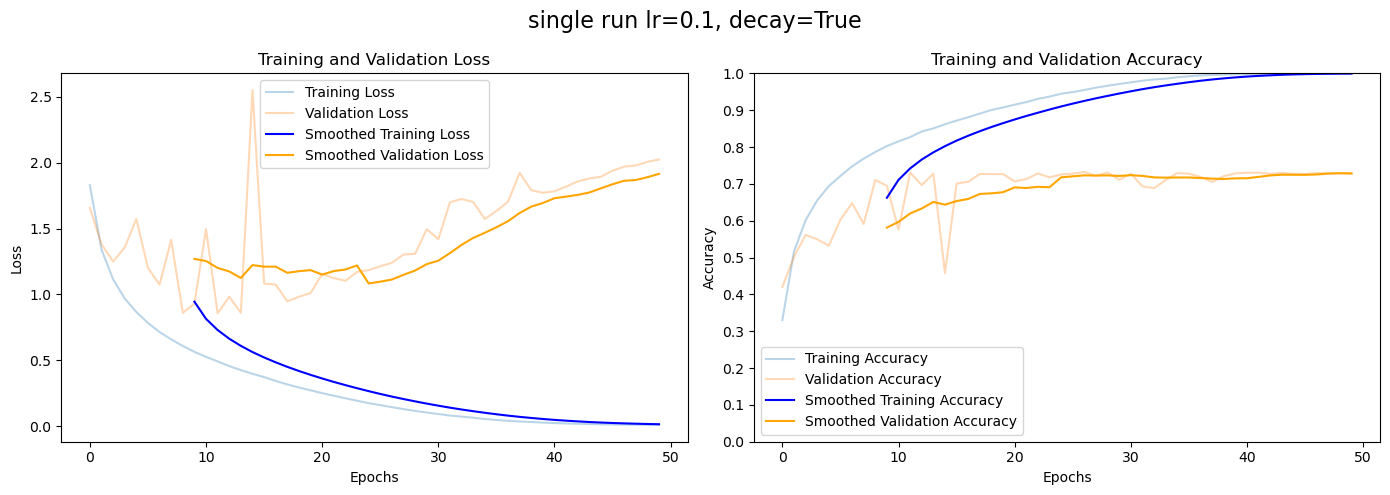

TESTING COMPLETE!!
Test Loss: 2.0444, Test Acc: 0.7235
              precision    recall  f1-score   support

       plane       0.77      0.76      0.77      1000
         car       0.83      0.83      0.83      1000
        bird       0.63      0.64      0.63      1000
         cat       0.51      0.53      0.52      1000
        deer       0.70      0.66      0.68      1000
         dog       0.63      0.62      0.62      1000
        frog       0.78      0.77      0.78      1000
       horse       0.76      0.78      0.77      1000
        ship       0.84      0.83      0.84      1000
       truck       0.80      0.81      0.80      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



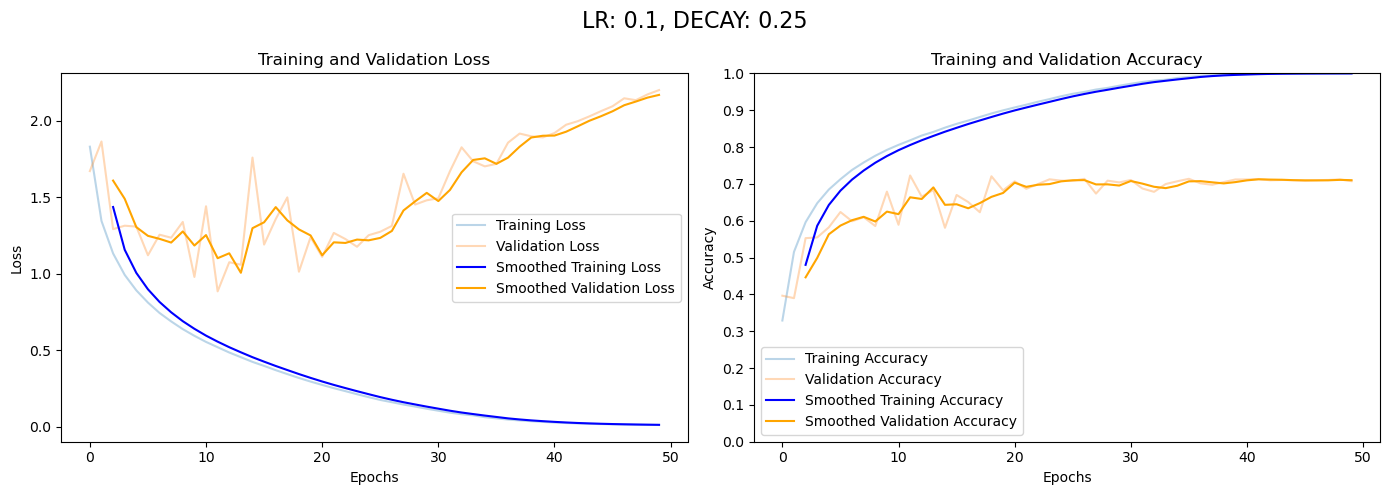

DECAY:  0.25
seed: 3
LR: 0.1
Epoch [1/50] - Train Loss: 1.8365, Acc: 0.3286 | Val Loss: 2.0654, Acc: 0.3232
LR: 0.08
Epoch [2/50] - Train Loss: 1.3256, Acc: 0.5231 | Val Loss: 1.4418, Acc: 0.4699
LR: 0.06666666666666667
Epoch [3/50] - Train Loss: 1.1000, Acc: 0.6103 | Val Loss: 1.5362, Acc: 0.4699
LR: 0.05714285714285715
Epoch [4/50] - Train Loss: 0.9495, Acc: 0.6659 | Val Loss: 1.1985, Acc: 0.6040
LR: 0.05
Epoch [5/50] - Train Loss: 0.8472, Acc: 0.7015 | Val Loss: 1.3742, Acc: 0.5378
LR: 0.044444444444444446
Epoch [6/50] - Train Loss: 0.7707, Acc: 0.7269 | Val Loss: 0.9891, Acc: 0.6590
LR: 0.04
Epoch [7/50] - Train Loss: 0.7047, Acc: 0.7530 | Val Loss: 1.6279, Acc: 0.5186
LR: 0.03636363636363637
Epoch [8/50] - Train Loss: 0.6474, Acc: 0.7733 | Val Loss: 0.9613, Acc: 0.6859
LR: 0.03333333333333333
Epoch [9/50] - Train Loss: 0.6002, Acc: 0.7891 | Val Loss: 1.8483, Acc: 0.4885
LR: 0.03076923076923077
Epoch [10/50] - Train Loss: 0.5584, Acc: 0.8042 | Val Loss: 1.0997, Acc: 0.6612
LR: 0.02

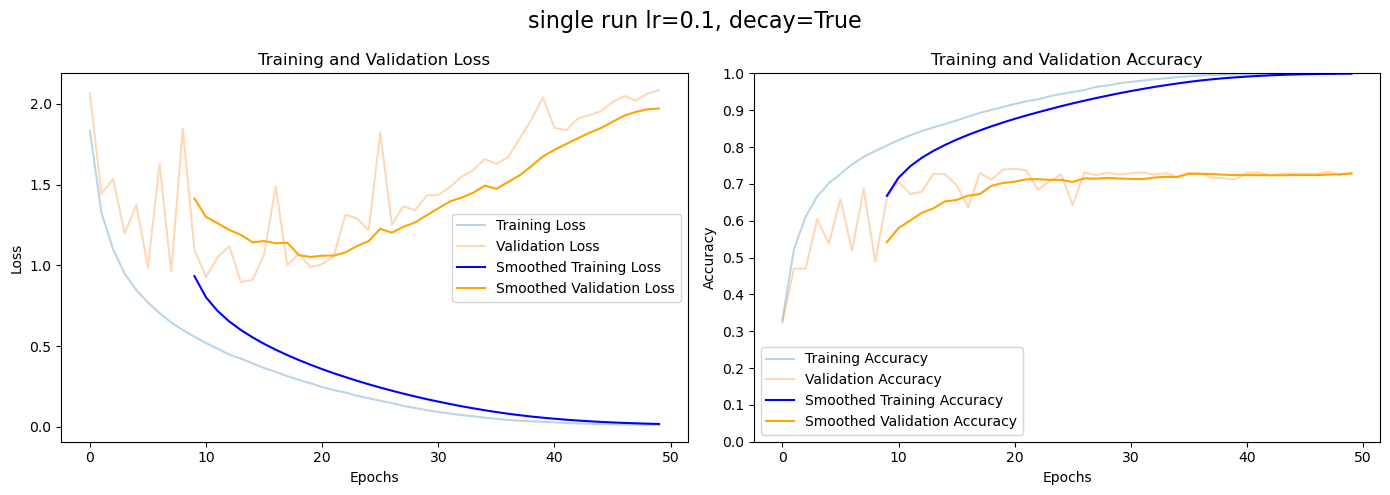

TESTING COMPLETE!!
Test Loss: 2.1380, Test Acc: 0.7163
              precision    recall  f1-score   support

       plane       0.74      0.79      0.77      1000
         car       0.84      0.83      0.84      1000
        bird       0.63      0.60      0.62      1000
         cat       0.52      0.53      0.53      1000
        deer       0.66      0.66      0.66      1000
         dog       0.61      0.61      0.61      1000
        frog       0.77      0.76      0.77      1000
       horse       0.76      0.76      0.76      1000
        ship       0.83      0.84      0.83      1000
       truck       0.80      0.78      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



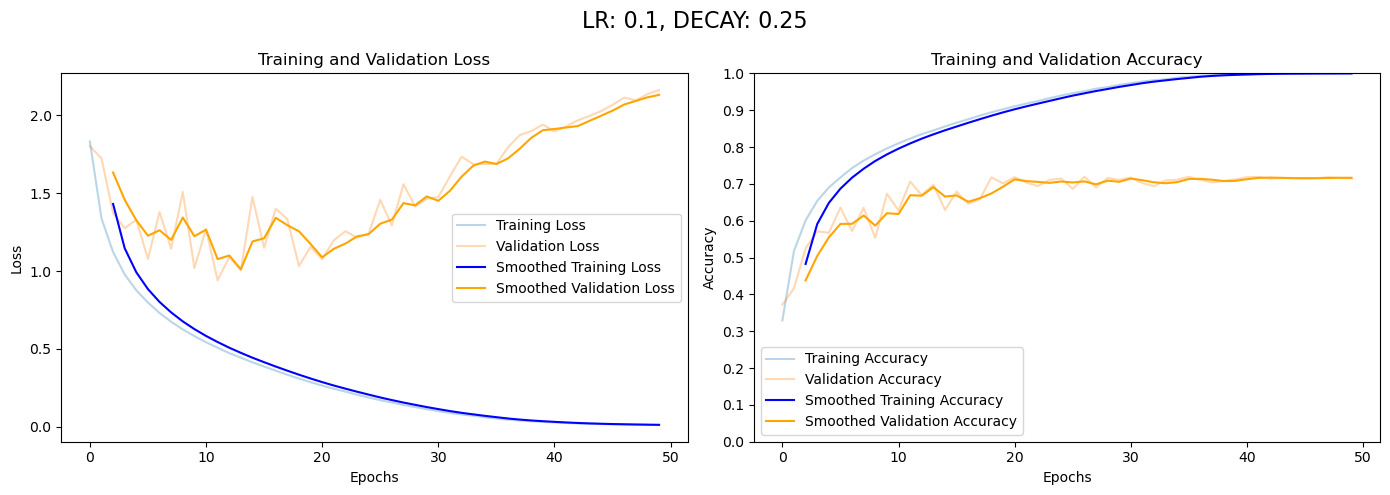

DECAY:  0.25
seed: 4
LR: 0.1
Epoch [1/50] - Train Loss: 1.8483, Acc: 0.3216 | Val Loss: 2.1115, Acc: 0.2638
LR: 0.08
Epoch [2/50] - Train Loss: 1.3178, Acc: 0.5257 | Val Loss: 2.8218, Acc: 0.2949
LR: 0.06666666666666667
Epoch [3/50] - Train Loss: 1.0898, Acc: 0.6150 | Val Loss: 1.2153, Acc: 0.5716
LR: 0.05714285714285715
Epoch [4/50] - Train Loss: 0.9389, Acc: 0.6688 | Val Loss: 1.1334, Acc: 0.6127
LR: 0.05
Epoch [5/50] - Train Loss: 0.8409, Acc: 0.7055 | Val Loss: 1.5494, Acc: 0.5354
LR: 0.044444444444444446
Epoch [6/50] - Train Loss: 0.7637, Acc: 0.7313 | Val Loss: 0.9275, Acc: 0.6792
LR: 0.04
Epoch [7/50] - Train Loss: 0.6983, Acc: 0.7561 | Val Loss: 1.1396, Acc: 0.6367
LR: 0.03636363636363637
Epoch [8/50] - Train Loss: 0.6456, Acc: 0.7731 | Val Loss: 0.9780, Acc: 0.6814
LR: 0.03333333333333333
Epoch [9/50] - Train Loss: 0.5972, Acc: 0.7902 | Val Loss: 0.9095, Acc: 0.7039
LR: 0.03076923076923077
Epoch [10/50] - Train Loss: 0.5572, Acc: 0.8069 | Val Loss: 0.9666, Acc: 0.6851
LR: 0.02

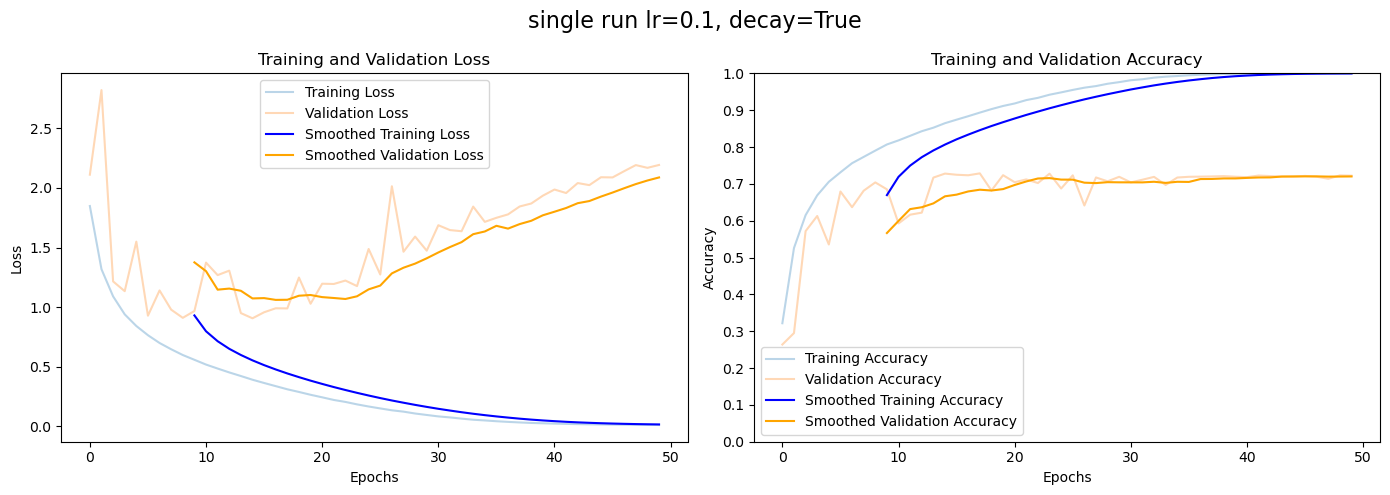

TESTING COMPLETE!!
Test Loss: 2.1005, Test Acc: 0.7175
              precision    recall  f1-score   support

       plane       0.76      0.74      0.75      1000
         car       0.84      0.83      0.83      1000
        bird       0.63      0.60      0.62      1000
         cat       0.52      0.54      0.53      1000
        deer       0.68      0.65      0.66      1000
         dog       0.61      0.61      0.61      1000
        frog       0.76      0.79      0.77      1000
       horse       0.77      0.77      0.77      1000
        ship       0.81      0.86      0.83      1000
       truck       0.80      0.79      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



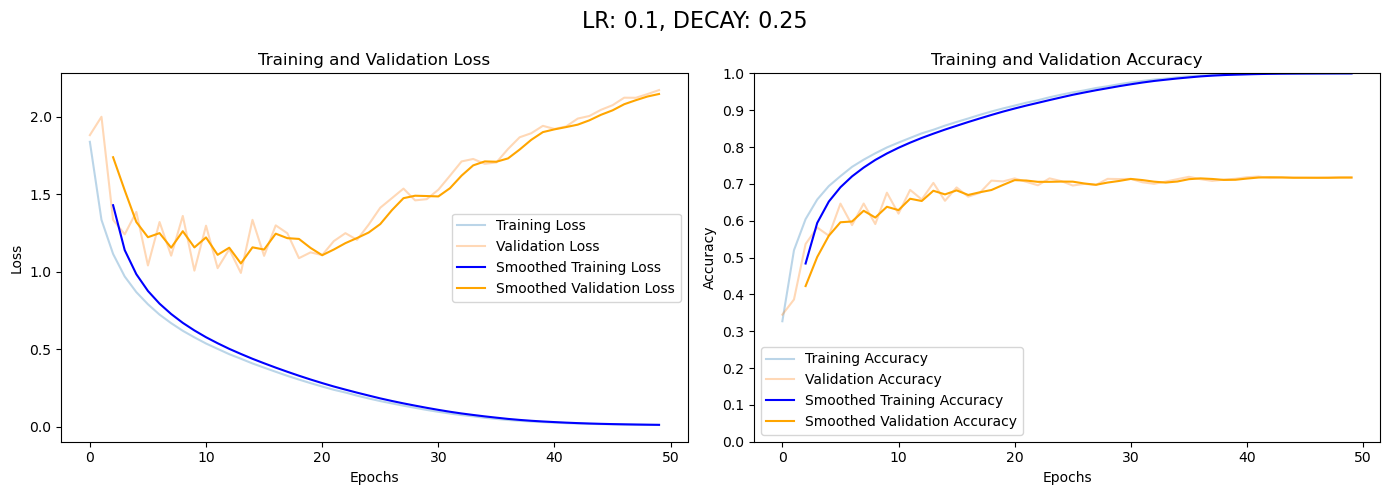

DECAY:  0.25
seed: 5
LR: 0.1
Epoch [1/50] - Train Loss: 1.7778, Acc: 0.3499 | Val Loss: 1.9046, Acc: 0.3469
LR: 0.08
Epoch [2/50] - Train Loss: 1.3193, Acc: 0.5236 | Val Loss: 1.5554, Acc: 0.4310
LR: 0.06666666666666667
Epoch [3/50] - Train Loss: 1.1045, Acc: 0.6066 | Val Loss: 1.2588, Acc: 0.5411
LR: 0.05714285714285715
Epoch [4/50] - Train Loss: 0.9662, Acc: 0.6589 | Val Loss: 1.3559, Acc: 0.5425
LR: 0.05
Epoch [5/50] - Train Loss: 0.8627, Acc: 0.6978 | Val Loss: 1.1155, Acc: 0.6228
LR: 0.044444444444444446
Epoch [6/50] - Train Loss: 0.7835, Acc: 0.7238 | Val Loss: 1.2208, Acc: 0.6084
LR: 0.04
Epoch [7/50] - Train Loss: 0.7229, Acc: 0.7470 | Val Loss: 0.9224, Acc: 0.6885
LR: 0.03636363636363637
Epoch [8/50] - Train Loss: 0.6623, Acc: 0.7701 | Val Loss: 1.2248, Acc: 0.6078
LR: 0.03333333333333333
Epoch [9/50] - Train Loss: 0.6153, Acc: 0.7828 | Val Loss: 0.8838, Acc: 0.6974
LR: 0.03076923076923077
Epoch [10/50] - Train Loss: 0.5720, Acc: 0.7994 | Val Loss: 1.0425, Acc: 0.6636
LR: 0.02

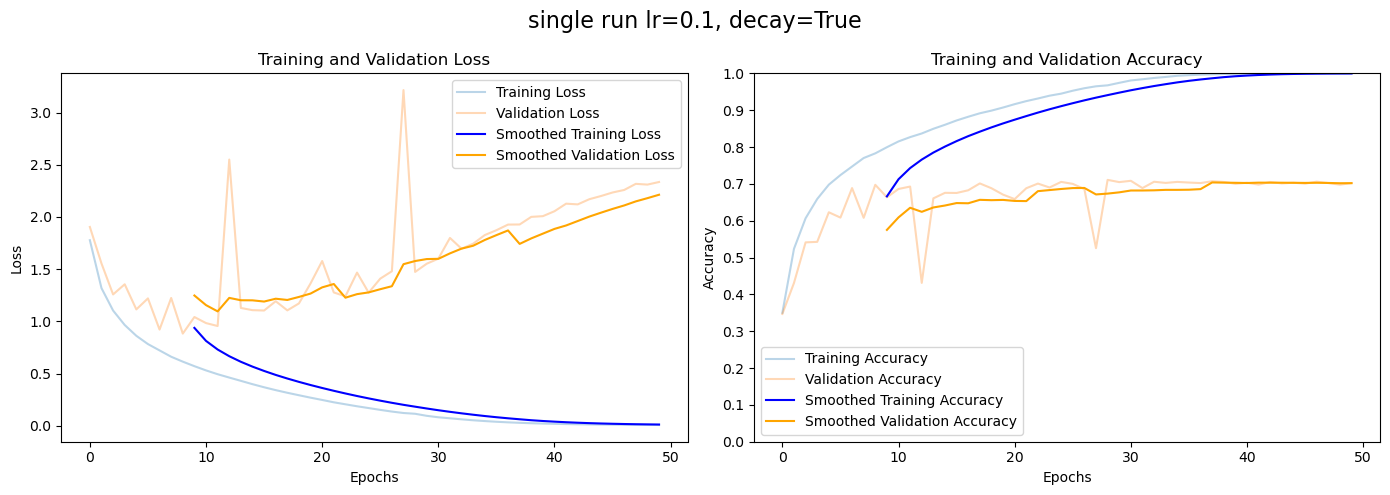

TESTING COMPLETE!!
Test Loss: 2.3502, Test Acc: 0.7047
              precision    recall  f1-score   support

       plane       0.73      0.75      0.74      1000
         car       0.83      0.83      0.83      1000
        bird       0.62      0.59      0.61      1000
         cat       0.50      0.49      0.50      1000
        deer       0.65      0.67      0.66      1000
         dog       0.61      0.60      0.60      1000
        frog       0.74      0.77      0.75      1000
       horse       0.74      0.74      0.74      1000
        ship       0.84      0.82      0.83      1000
       truck       0.77      0.78      0.78      1000

    accuracy                           0.71     10000
   macro avg       0.70      0.71      0.70     10000
weighted avg       0.70      0.71      0.70     10000



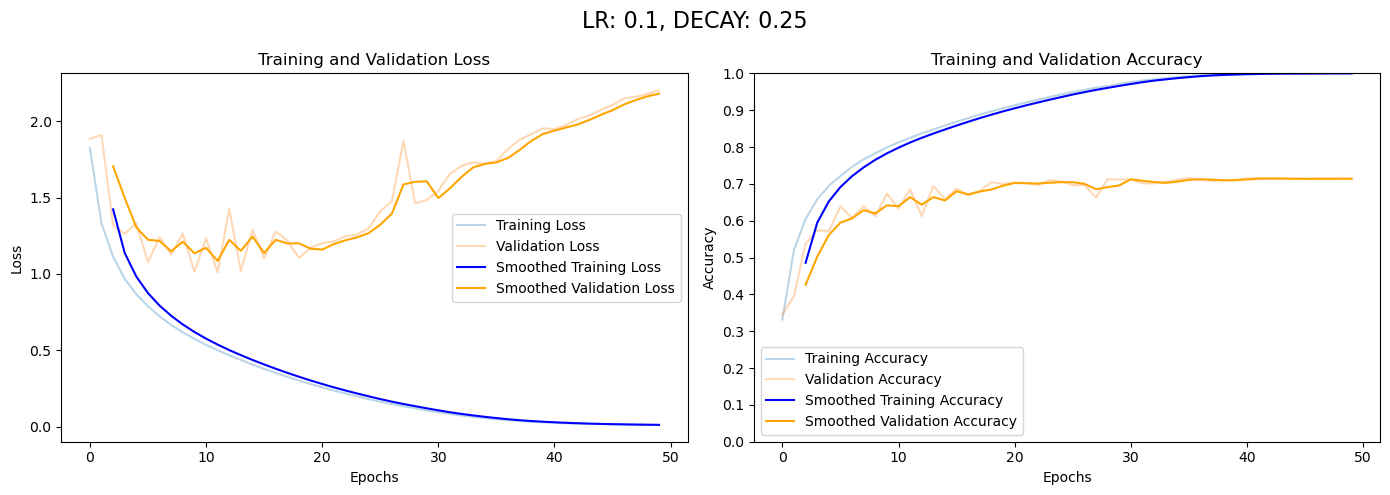

In [23]:
# Experiment 1.2 - LR decay

def adjust_initial_learning_rate(optimiser, epoch, initial_lr=0.1, decay_rate=0.25):    
    new_lr = initial_lr / (1 + decay_rate *epoch)
    for param_group in optimiser.param_groups:
        param_group['lr'] = new_lr
    print('LR:',new_lr)
    return optimiser

num_epochs = 50

initial_learning_rate = 0.1
decay_rate = 0.25

random_seeds = list(range(1, 6))

averaged_results = {decay_rate:{}}
path_to_save = f'./run_data/lr_decay/final_decaying_lr_initial_lr_{initial_learning_rate}_decay_{decay_rate}.json'
path_to_load = f'./run_data/lr_decay/final_decaying_lr_initial_lr_{initial_learning_rate}_decay_{decay_rate}.json'

save_experiment = True

  
epoch_train_losses_by_run = []
epoch_val_losses_by_run = []
epoch_train_accuracies_by_run = []
epoch_val_accuracies_by_run = []
test_losses = []
test_accuracies = []
reports = []
    
for random_seed in random_seeds:
    print('DECAY: ', decay_rate)
    print('seed:', random_seed)
    torch.manual_seed(random_seed)

    model = BaselineNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = optim.SGD(model.parameters(), lr=initial_learning_rate)

    model,train_epoch_losses, train_epoch_accuracy, val_epoch_losses, val_epoch_accuracy, train_report,val_report = run_training_and_validation(model, device, initial_learning_rate, num_epochs, criterion, optimiser, train_dataloader, val_dataloader, manual_lr_schedule=True, scheduler_func=adjust_initial_learning_rate, plot=True)
    epoch_train_losses_by_run.append(train_epoch_losses)
    epoch_val_losses_by_run.append(val_epoch_losses)
    epoch_train_accuracies_by_run.append(train_epoch_accuracy)
    epoch_val_accuracies_by_run.append(val_epoch_accuracy)
    
    test_loss, test_accuracy, report = run_testing(model, device, criterion, test_dataloader)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    reports.append(report)

    
    average_train_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_train_losses_by_run)]
    average_val_losses = [sum(epoch_losses) / len(epoch_losses) for epoch_losses in zip(*epoch_val_losses_by_run)]
    average_train_accuracies = [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_train_accuracies_by_run)]
    average_val_accuracies =  [sum(epoch_accuracies) / len(epoch_accuracies) for epoch_accuracies in zip(*epoch_val_accuracies_by_run)]
    average_test_loss = sum(test_losses)/len(test_losses)
    average_test_accuracy = sum(test_accuracies)/len(test_accuracies)
    
    averaged_results[decay_rate] = {'seeds':random_seeds,
                                       'av_train_losses': average_train_losses,
                                       'av_val_losses': average_val_losses,
                                       'av_train_acc': average_train_accuracies,
                                       'av_val_acc': average_val_accuracies,
                                       'all_train_losses':epoch_train_losses_by_run,
                                       'all_val_losses': epoch_val_losses_by_run,
                                       'all_train_accuracies': epoch_train_accuracies_by_run,
                                       'all_val_accuracies': epoch_val_accuracies_by_run,
                                       'all_test_losses':test_losses, 
                                       'all_test_accuracies':test_accuracies,
                                       'av_test_loss': average_test_loss,
                                       'av_test_accuracy':average_test_accuracy}
    
    plot_single_train_val_smoothed(average_train_losses,average_val_losses,average_train_accuracies,average_val_accuracies, num_epochs, smoothing_window=3, title=f'LR: {initial_learning_rate}, DECAY: {decay_rate}')
    
if save_experiment:
    with open(path_to_save, 'w') as file:
        json.dump(averaged_results, file, indent=4)  # 'indent' makes the output formatted and easier to read

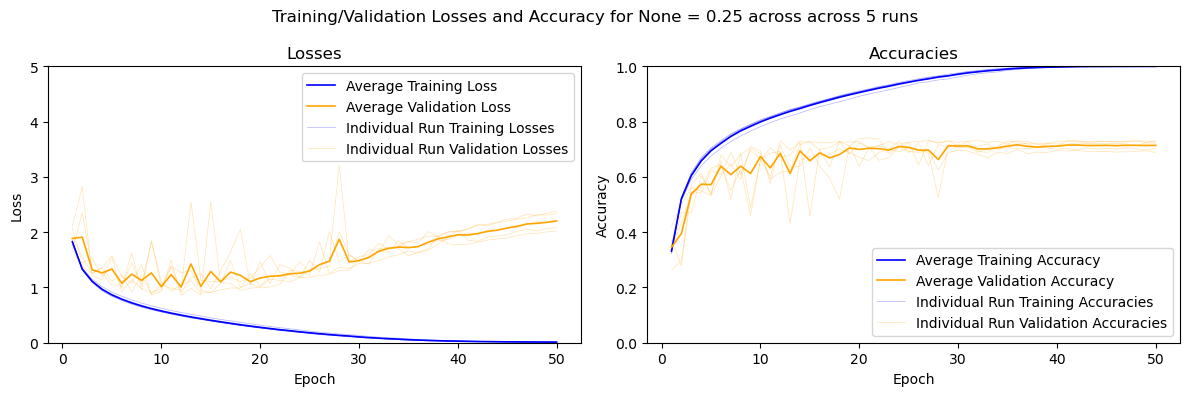

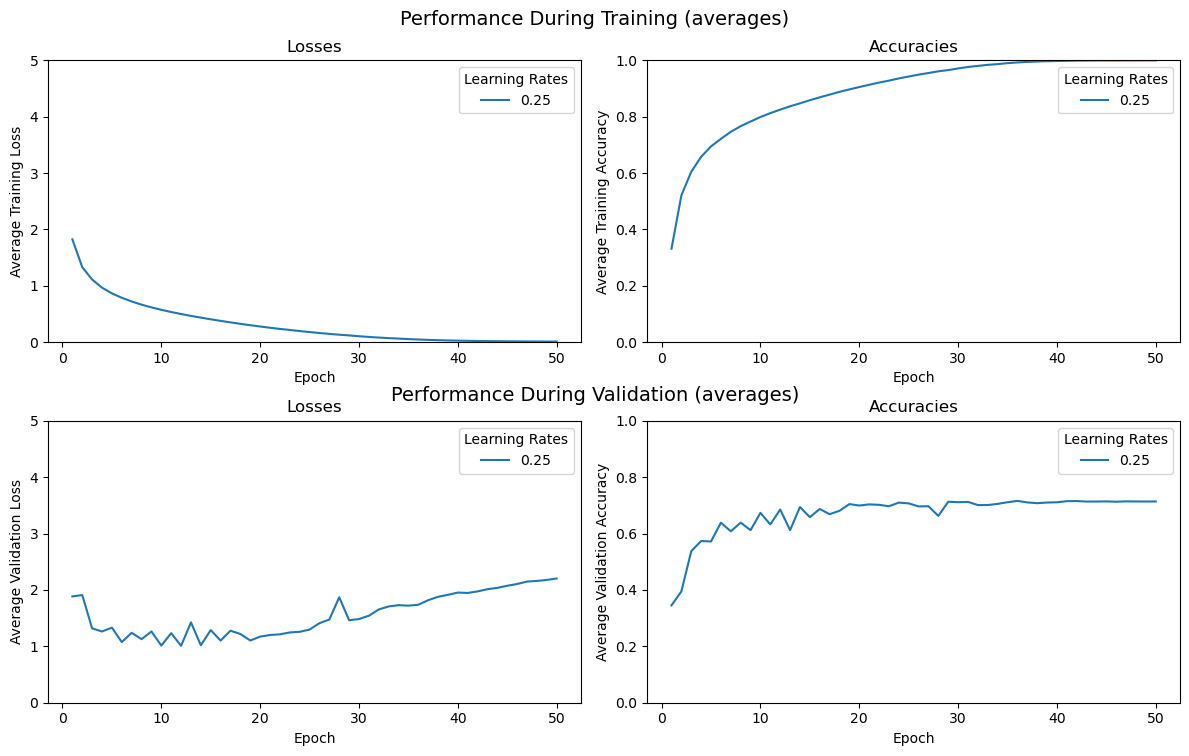

hi


,Average Test Loss,Average Test Accuracy
0.25,2.198504,0.711803


In [25]:
lr_decay_data = path_to_load
plot_all_models_performance_from_disk(lr_decay_data, enforce_axis=True)
plot_performance_comparison_from_file(lr_decay_data, enforce_axis=True)
display_accuracy_heatmap(lr_decay_data)